In [ ]:
import numpy as np
import pandas as pd

import os
print(os.listdir("../input"))

['train.json', 'test.json', 'sample.csv']


In [ ]:
import json

test_file = '../input/test.json'
train_file = '../input/train.json'

x_train, y_train, x_test, test_inds = [], [], [], []

with open(test_file) as json_file:
    data = json.load(json_file)

    for row in data:
        x_test.append(row['text'])
        test_inds.append(row['id'])

with open(train_file) as json_file:
    data = json.load(json_file)

    for row in data:
        sentiment = -1

        if row['sentiment'] == 'negative':
            sentiment = 0
        elif row['sentiment'] == 'neutral':
            sentiment = 1
        else:
            sentiment = 2

        if sentiment == -1:
            continue

        x_train.append(row['text'])
        y_train.append(sentiment)

print('Train sentences: {}'.format(len(x_train)))
print('Train labels: {}'.format(len(y_train)))
print('Test sentences: {}'.format(len(x_test)))

Train sentences: 8263
Train labels: 8263
Test sentences: 2056


In [ ]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

max_length = 5000
max_features = 20000
embedding_dim = 300

x_all = []
x_all.extend(x_test)
x_all.extend(x_train)

tk = Tokenizer(num_words=max_features, lower=True, filters='\n\t')
tk.fit_on_texts(x_all)
x_train_seq = tk.texts_to_sequences(x_train)
x_test_seq = tk.texts_to_sequences(x_test)

np_x_train = pad_sequences(x_train_seq, maxlen=max_length,  padding='post')
np_x_test = pad_sequences(x_test_seq, maxlen=max_length,  padding='post')
np_y_train = to_categorical(y_train)

class_num = np_y_train.shape[1]

print ('np_x_train shape: {}'.format(np_x_train.shape))
print ('np_x_test shape: {}'.format(np_x_test.shape))
print ('np_y_train shape: {}'.format(np_y_train.shape))

Using TensorFlow backend.


np_x_train shape: (8263, 5000)
np_x_test shape: (2056, 5000)
np_y_train shape: (8263, 3)


In [ ]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping

def one_input_classifier(max_length, max_features, embedding_dim, class_num):
    inputs = Input(shape=(max_length,), name='input_1')
    embeddings = Embedding(max_features, embedding_dim, input_length=max_length, name='embedding_1')(inputs)

    conv_1 = Conv1D(32, 9, activation='relu', name='conv1d_1')(embeddings)
    maxpool_1 = MaxPooling1D(16, name='maxpool1d_1')(conv_1)
    dropout_1 = Dropout(0.2, name='dropout_1')(maxpool_1)

    conv_2 = Conv1D(32, 7, activation='relu', name='conv1d_2')(dropout_1)
    maxpool_2 = MaxPooling1D(8, name='maxpool1d_2')(conv_2)
    dropout_2 = Dropout(0.2, name='dropout_2')(maxpool_2)

    bilstm = Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2, name='lstm_1'),
        name='bidirectional_1')(dropout_2)
    preds = Dense(class_num, activation='softmax', name='preds')(bilstm)

    model = Model(inputs=inputs, outputs=preds)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1,
                               mode='min', baseline=None, restore_best_weights=True)

models = []
classifier_num = 10

for i in range(classifier_num):
    model = one_input_classifier(max_length, max_features, embedding_dim, class_num)

    if i == 0:
        print(model.summary())

    model.fit(np_x_train, np_y_train, validation_split=0.3, shuffle=True,
              callbacks=[early_stopping], epochs=10, batch_size=32, verbose=1)
    models.append(model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 5000, 300)         6000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4992, 32)          86432     
_________________________________________________________________
maxpool1d_1 (MaxPooling1D)   (None, 312, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 312, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)    

In [ ]:
y_pred_list = []

for i in range(classifier_num):
    y_pred = models[i].predict(np_x_test, batch_size=32, verbose=1)
    y_pred_list.append(y_pred)

print(len(y_pred_list))

2056/2056 [==============================] - 5s 2ms/step
10


In [ ]:
test_num = np_x_test.shape[0]
y_pred = np.ndarray(shape=(test_num,), dtype=np.int32)

for i in range(test_num):
    votes = []

    for j in range(classifier_num):
        vote = y_pred_list[j][i].argmax(axis=0).astype(int)
        votes.append(vote)

    vote_final = max(set(votes), key=votes.count)
    y_pred[i] = vote_final

predicted_classes = []
filename = 'submission.csv'

for i, y_val in enumerate(y_pred):
    if y_val == 0:
        predicted_classes.append((test_inds[i], 'negative'))
    elif y_val == 1:
        predicted_classes.append((test_inds[i], 'neutral'))
    else:
        predicted_classes.append((test_inds[i], 'positive'))

sub = pd.DataFrame(data=predicted_classes, columns=['id', 'sentiment'])
sub.to_csv(filename, index=False)
print(sub.head())

   id sentiment
0   0  positive
1   1  positive
2   2  negative
3   3  positive
4   4  negative


<Axes: >

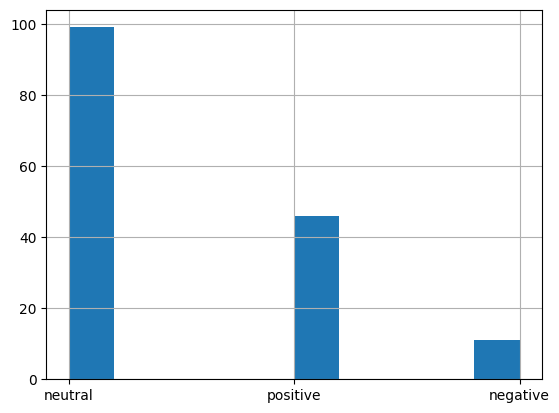

In [ ]:
sub["sentiment"].hist()